In [1]:
import librosa
import scipy
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import librosa.display
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from torch.autograd import Variable

class LearnedGroupConv1D(nn.Module):
    global_progress = 0.0
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, condense_factor=None, dropout_rate=0.):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.condense_factor = condense_factor
        self.groups = groups
        self.dropout_rate = dropout_rate

        # Check if given configs are valid
        assert self.in_channels % self.groups == 0, "group value is not divisible by input channels"
        assert self.in_channels % self.condense_factor == 0, "condensation factor is not divisible by input channels"
        assert self.out_channels % self.groups == 0, "group value is not divisible by output channels"

        self.conv = nn.Conv1d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding, dilation=dilation, groups=1, bias=True)
        if self.dropout_rate > 0:
            self.dropout = nn.Dropout(self.dropout_rate, inplace=False)
        # register conv buffers
        self.register_buffer('_count', torch.zeros(1))
        self.register_buffer('_stage', torch.zeros(1))
        self.register_buffer('_mask', torch.ones(self.conv.weight.size()))

    def forward(self, x):
        # To mask the output
        weight = self.conv.weight * self.mask
        weight_bias = self.conv.bias
        out = F.conv1d(input=x, weight=weight, bias=weight_bias, stride=self.conv.stride, 
                            padding=self.conv.padding, dilation=self.conv.dilation, groups=1)
        ## Dropping here ##
        self.check_if_drop()
        if self.dropout_rate > 0:
            out = self.dropout(out)
        return out

    """
    Paper: Sec 3.1: Condensation procedure: number of epochs for each condensing stage: M/2(C-1)
    Paper: Sec 3.1: Condensation factor: allow each group to select R/C of inputs.
    - During training a fraction of (C−1)/C connections are removed after each of the C-1 condensing stages
    - we remove columns in Fg (by zeroing them out) if their L1-norm is small compared to the L1-norm of other columns.
    """
    def check_if_drop(self):
        current_progress = LearnedGroupConv1D.global_progress
        delta = 0
        # Get current stage
        for i in range(self.condense_factor - 1):   # 3 condensation stages
            if current_progress * 2 < (i + 1) / (self.condense_factor - 1):
                stage = i
                break
        else:
            stage = self.condense_factor - 1
        # Check for actual dropping
        if not self.reach_stage(stage):
            self.stage = stage
            delta = self.in_channels // self.condense_factor
            print(delta)
        if delta > 0:
            self.drop(delta)
        return

    def drop(self, delta):
        weight = self.conv.weight * self.mask
        # Sum up all kernels
        print(weight.size())
        assert weight.size()[-1] == 1
        weight = weight.abs().squeeze()
        assert weight.size()[0] == self.out_channels
        assert weight.size()[1] == self.in_channels
        d_out = self.out_channels // self.groups
        print(d_out.size())
        # Shuffle weights
        weight = weight.view(d_out, self.groups, self.in_channels)
        print(weight.size())

        weight = weight.transpose(0, 1).contiguous()
        print(weight.size())

        weight = weight.view(self.out_channels, self.in_channels)
        print(weight.size())
        # Sort and drop
        for i in range(self.groups):
            wi = weight[i * d_out:(i + 1) * d_out, :]
            # Take corresponding delta index
            di = wi.sum(0).sort()[1][self.count:self.count + delta]
            for d in di.data:
                self._mask[i::self.groups, d, :, :].fill_(0)
        self.count = self.count + delta

    def reach_stage(self, stage):
        return (self._stage >= stage).all()

    @property
    def count(self):
        return int(self._count[0])

    @count.setter
    def count(self, val):
        self._count.fill_(val)

    @property
    def stage(self):
        return int(self._stage[0])

    @stage.setter
    def stage(self, val):
        self._stage.fill_(val)

    @property
    def mask(self):
        return Variable(self._mask)

def _bn_function_factory(conv, norm, prelu):
    def bn_function(*inputs):
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = norm(prelu(conv(concated_features)))
        return bottleneck_output

    return bn_function

class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate):
        super(_DenseLayer, self).__init__()
        
        self.conv0 = LearnedGroupConv1D(num_input_features, 4 * growth_rate, kernel_size=3, padding=1, groups=4, condense_factor=4)
        self.norm0 = nn.BatchNorm1d(4 * growth_rate)

        self.PReLU = nn.PReLU(num_parameters=1, init=0.05)
        
        self.conv1 = LearnedGroupConv1D(4 * growth_rate, growth_rate, kernel_size=3, padding=1, groups=8, condense_factor=8)
        self.norm1 = nn.BatchNorm1d(growth_rate)

    def forward(self, *prev_features):
        bn_function = _bn_function_factory(self.conv0, self.norm0, self.PReLU)
        if any(prev_feature.requires_grad for prev_feature in prev_features):
            bottleneck_output = cp.checkpoint(bn_function, *prev_features)
        else:
            bottleneck_output = bn_function(*prev_features)
        new_features = self.norm1(self.conv1(bottleneck_output))
        return new_features
    
class _DenseBlock(nn.Module):
    def __init__(self, nChannels, growth_rate):
        super(_DenseBlock, self).__init__()
        layer = _DenseLayer(nChannels, growth_rate)
        self.add_module('denselayer', layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.named_children():
            new_features = layer(*features)
            features.append(new_features)
        return torch.cat(features, 1)


class EdgeRNN(nn.Module):
    def __init__(self, num_class):
        super(EdgeRNN, self).__init__()

        self.output_size = num_class
        num_features = 152
        growth_rate = 16
        
#         self.conv0 = LearnedGroupConv1D(num_features, num_features, kernel_size=1, padding=0, groups=4, condense_factor=4)
        self.dense1 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense2 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense3 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense4 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense5 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense6 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense7 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense8 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense9 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense10 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense11 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        self.dense12 = _DenseBlock(num_features,growth_rate)
        num_features = num_features + growth_rate
        
        self.MaxPool1d = nn.MaxPool1d(2,2)
        
        self.RNN = nn.RNN(num_features, num_features, 1, batch_first=True,
                              dropout=0,bidirectional=False)
        self.Tanh = nn.Tanh()
        self.out = nn.Linear(num_features, self.output_size)

    
    def forward(self, x):
        
        x = x.float()
        
#         x = self.conv0(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense6(x)
        x = self.dense7(x)
        x = self.dense8(x)
        x = self.dense9(x)
        x = self.dense10(x)
        x = self.dense11(x)
        x = self.dense12(x)
        
        x = self.MaxPool1d(x)
        
        x = x.permute(0, 2, 1)
        x, h_n = self.RNN(x)
        
        residual = x 
        x = F.sigmoid(x)
        residual = residual * x
        residual = (residual.sum(1)) / (x.sum(1))
        residual = self.Tanh(residual)

        x = self.out(residual)
        
        return x

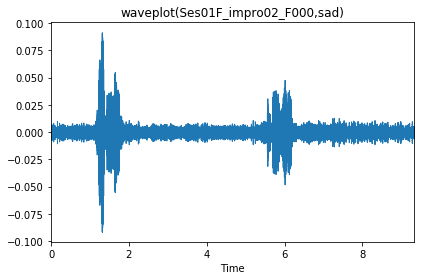

In [2]:
def extract_features(S, sr):
    
    if S.shape[0] > 92585:
        S = S[:92585]
    else:
        S = np.pad(S, (0, 92585-S.shape[0]), 'constant')
    
    S_spectrogram = librosa.feature.melspectrogram(y=S, sr=sr, n_mels=128)  # spectrogram features
    S = librosa.power_to_db(S_spectrogram)
    S = scipy.fftpack.dct(S, axis=0, type=2, norm='ortho')[:12]  # MFCC features
    
    S_delta = librosa.feature.delta(S)
    S_delta2 = librosa.feature.delta(S, order=2)
    
    S = np.vstack([S_spectrogram, S_delta, S_delta2])     
    
    return S

sad_wav_vector, _sr = librosa.load('data/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro02/Ses01F_impro02_F000.wav', sr=16000)

librosa.display.waveplot(sad_wav_vector, _sr)
plt.title('waveplot(Ses01F_impro02_F000,sad)')
plt.tight_layout()
plt.savefig("waveplot.png")
plt.show()
        
sad = extract_features(sad_wav_vector, _sr)

net = EdgeRNN(num_class=4) 

Private_checkpoint = torch.load('IEMOCAP_Test_model.pt')
net.load_state_dict(Private_checkpoint['net'], strict=False)
for p in net.parameters():
    p.requires_grad = False
for p in net.parameters():
    p.requires_grad = False

dense1


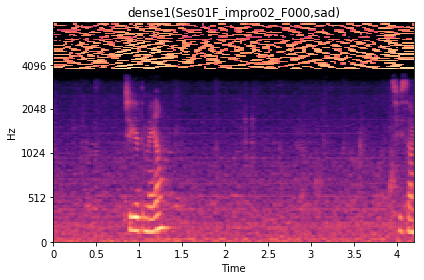

dense2


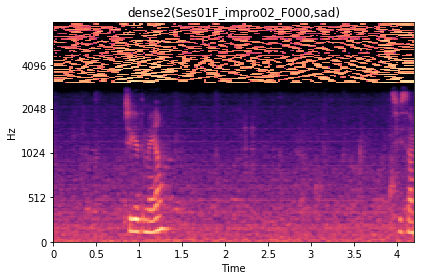

dense3


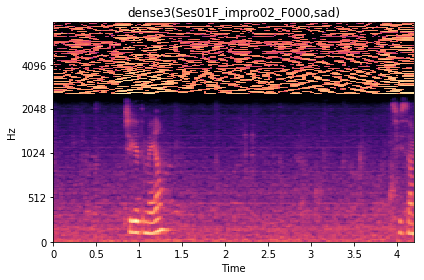

dense4


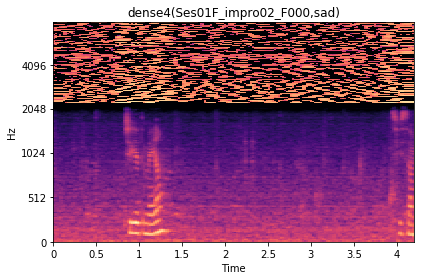

dense5


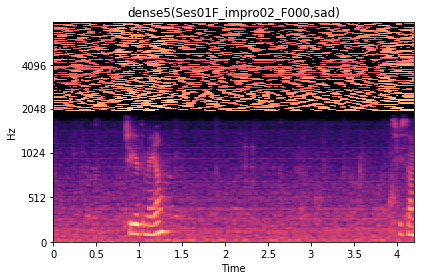

dense6


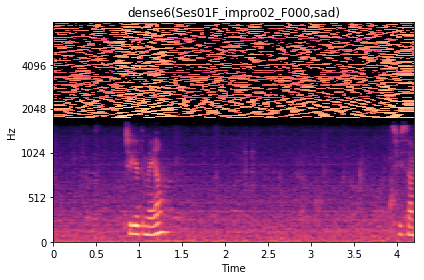

dense7


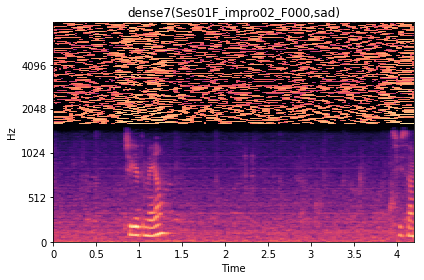

dense8


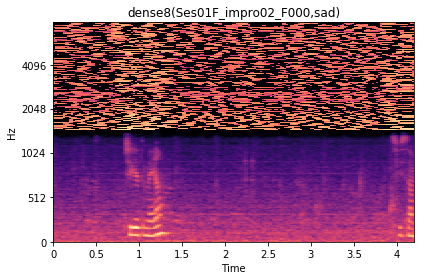

dense9


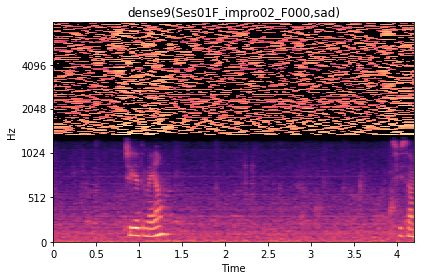

dense10


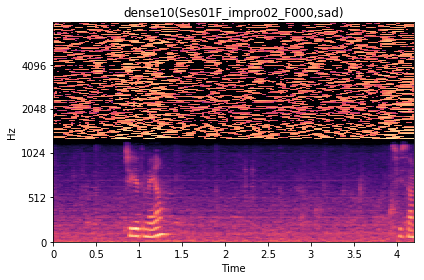

dense11


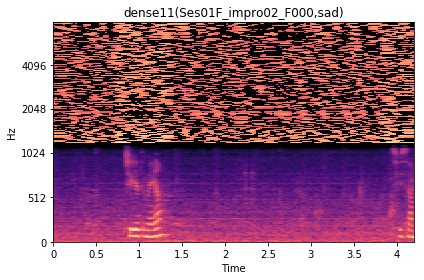

dense12


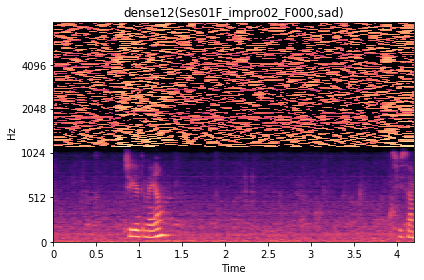

MaxPool1d


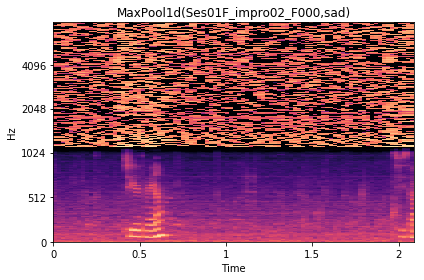

RNN


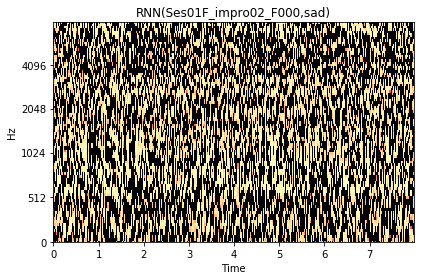

Tanh


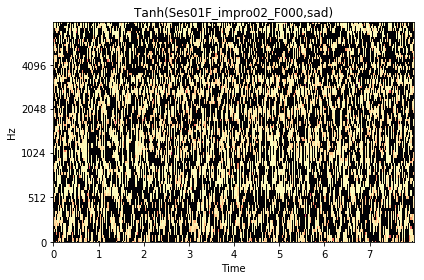

out


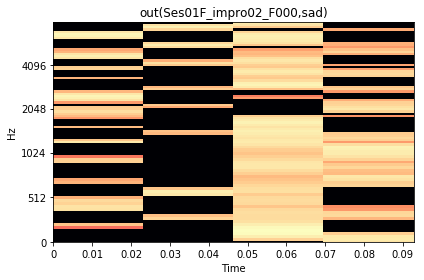

In [3]:
sad = torch.from_numpy(sad)
sad = sad.unsqueeze(0)
sad = sad.double()
net = net.double()
for name, module in net._modules.items():
    sad = module(sad)
    print (name)
    if name == 'dense1':
        librosa.display.specshow(librosa.power_to_db(sad.squeeze(0),ref=np.max), y_axis='mel', fmax=8000,x_axis='time')
        plt.title('dense1(Ses01F_impro02_F000,sad)')
        plt.tight_layout()
        plt.savefig("dense1.png")
        plt.show()
    elif name == 'dense2':
        librosa.display.specshow(librosa.power_to_db(sad.squeeze(0),ref=np.max), y_axis='mel', fmax=8000,x_axis='time')
        plt.title('dense2(Ses01F_impro02_F000,sad)')
        plt.tight_layout()
        plt.savefig("dense2.png")
        plt.show()
    elif name == 'dense3':
        librosa.display.specshow(librosa.power_to_db(sad.squeeze(0),ref=np.max), y_axis='mel', fmax=8000,x_axis='time')
        plt.title('dense3(Ses01F_impro02_F000,sad)')
        plt.tight_layout()
        plt.savefig("dense3.png")
        plt.show()
    elif name == 'dense4':
        librosa.display.specshow(librosa.power_to_db(sad.squeeze(0),ref=np.max), y_axis='mel', fmax=8000,x_axis='time')
        plt.title('dense4(Ses01F_impro02_F000,sad)')
        plt.tight_layout()
        plt.savefig("dense4.png")
        plt.show()
    elif name == 'dense5':
        librosa.display.specshow(librosa.power_to_db(sad.squeeze(0),ref=np.max), y_axis='mel', fmax=8000,x_axis='time')
        plt.title('dense5(Ses01F_impro02_F000,sad)')
        plt.tight_layout()
        plt.savefig("dense5.png")
        plt.show()
    elif name == 'dense6':
        librosa.display.specshow(librosa.power_to_db(sad.squeeze(0),ref=np.max), y_axis='mel', fmax=8000,x_axis='time')
        plt.title('dense6(Ses01F_impro02_F000,sad)')
        plt.tight_layout()
        plt.savefig("dense6.png")
        plt.show()
    elif name == 'dense7':
        librosa.display.specshow(librosa.power_to_db(sad.squeeze(0),ref=np.max), y_axis='mel', fmax=8000,x_axis='time')
        plt.title('dense7(Ses01F_impro02_F000,sad)')
        plt.tight_layout()
        plt.savefig("dense7.png")
        plt.show()
    elif name == 'dense8':
        librosa.display.specshow(librosa.power_to_db(sad.squeeze(0),ref=np.max), y_axis='mel', fmax=8000,x_axis='time')
        plt.title('dense8(Ses01F_impro02_F000,sad)')
        plt.tight_layout()
        plt.savefig("dense8.png")
        plt.show()
    elif name == 'dense9':
        librosa.display.specshow(librosa.power_to_db(sad.squeeze(0),ref=np.max), y_axis='mel', fmax=8000,x_axis='time')
        plt.title('dense9(Ses01F_impro02_F000,sad)')
        plt.tight_layout()
        plt.savefig("dense9.png")
        plt.show()
    elif name == 'dense10':
        librosa.display.specshow(librosa.power_to_db(sad.squeeze(0),ref=np.max), y_axis='mel', fmax=8000,x_axis='time')
        plt.title('dense10(Ses01F_impro02_F000,sad)')
        plt.tight_layout()
        plt.savefig("dense10.png")
        plt.show()
    elif name == 'dense11':
        librosa.display.specshow(librosa.power_to_db(sad.squeeze(0),ref=np.max), y_axis='mel', fmax=8000,x_axis='time')
        plt.title('dense11(Ses01F_impro02_F000,sad)')
        plt.tight_layout()
        plt.savefig("dense11.png")
        plt.show()
    elif name == 'dense12':
        librosa.display.specshow(librosa.power_to_db(sad.squeeze(0),ref=np.max), y_axis='mel', fmax=8000,x_axis='time')
        plt.title('dense12(Ses01F_impro02_F000,sad)')
        plt.tight_layout()
        plt.savefig("dense12.png")
        plt.show()
        
    elif name == 'MaxPool1d':
        librosa.display.specshow(librosa.power_to_db(sad.squeeze(0),ref=np.max), y_axis='mel', fmax=8000,x_axis='time')
        sad = sad.permute(0, 2, 1)
        plt.title('MaxPool1d(Ses01F_impro02_F000,sad)')
        plt.tight_layout()
        plt.savefig("MaxPool1d.png")
        plt.show()
    elif name == 'RNN':
        sad, _ = sad
        librosa.display.specshow(librosa.power_to_db(sad.squeeze(0),ref=np.max), y_axis='mel', fmax=8000,x_axis='time')
        plt.title('RNN(Ses01F_impro02_F000,sad)')
        plt.tight_layout()
        plt.savefig("RNN.png")
        plt.show()
    elif name == 'Tanh':
        librosa.display.specshow(librosa.power_to_db(sad.squeeze(0),ref=np.max), y_axis='mel', fmax=8000,x_axis='time')
        plt.title('Tanh(Ses01F_impro02_F000,sad)')
        plt.tight_layout()
        plt.savefig("Tanh.png")
        plt.show()
    elif name == 'out':
        librosa.display.specshow(librosa.power_to_db(sad.squeeze(0),ref=np.max), y_axis='mel', fmax=8000,x_axis='time')
        plt.title('out(Ses01F_impro02_F000,sad)')
        plt.tight_layout()
        plt.savefig("out.png")
        plt.show()